# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### 1) Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Data Analysis Objective

A car dealership’s objective is to correctly estimate fair-market listing prices for used vehicles.  This is necessary to support business decisoin-making with respect to acquisition bids, retail pricing, trade-in offers, and markdown cadence. 

Our data analysis objective is to develop a predictive function f(X)→log(price) from vehicle attributes (nominal/ordinal categoricals like fuel, drive, type, odometer_bin; and numerics like model year, odometer miles), using a train/test split and optimizing generalization error (MSE on the log scale).

We will compare three modeling families:

- a multiple linear regression with One-Hot encoding as an interpretable baseline;

- a polynomial regression (degree sweep) to capture any nonlinearities and interactions; and

- a Ridge-regularized linear regression with a cross-validated alpha sweep.

Deliverables should include the best model selection and feature effect estimates that will translate the model outputs into pricing and acquisition recommendations for decision-makers in the used car business.

### 2) Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [843]:
import warnings, os, re, math
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  GridSearchCV, KFold
from sklearn.metrics import mean_squared_error #
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,  PolynomialFeatures 


In [844]:
data_raw = pd.read_csv("data/vehicles.csv")

In [845]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [846]:
data_raw.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


#### Review data for Missing values



In [847]:
isNull = pd.DataFrame(pd.concat([data_raw.isna().sum(), (data_raw.isna().sum()/data_raw.shape[0]*100)], axis=1) )
isNull.columns = ['nullCount','nullPct']

isNull

,nullCount,nullPct
id,0,0.000000
region,0,0.000000
price,0,0.000000
year,1205,0.282281
manufacturer,17646,4.133714
model,5277,1.236179
condition,174104,40.785232
cylinders,177678,41.622470
fuel,3013,0.705819
odometer,4400,1.030735


#### Identify Categorical vs Numeric data columns



In [848]:
categorical_cols = []
numerical_cols = []
for col in data_raw.columns: 
    if data_raw[col].dtypes == 'object':
        categorical_cols.append(col)
    else: 
        numerical_cols.append(col)

print(categorical_cols)
print(numerical_cols)

['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']
['id', 'price', 'year', 'odometer']


#### Review unique values within Categorical columns



In [849]:
for col in categorical_cols:
    print(f"Unique values in '{col}' has {data_raw[col].unique().shape[0]} unique values:")
    print(pd.Series(data_raw[col].unique()).str.lower().sort_values())
    print("----")


Unique values in 'region' has 404 unique values:
342                   abilene
279            akron / canton
98                     albany
252               albuquerque
310         altoona-johnstown
                ...          
322                      york
292                youngstown
64                yuba-sutter
31                       yuma
293    zanesville / cambridge
Length: 404, dtype: object
----
Unique values in 'manufacturer' has 43 unique values:
22              acura
20         alfa-romeo
40       aston-martin
17               audi
25                bmw
14              buick
9            cadillac
2           chevrolet
15           chrysler
39             datsun
11              dodge
31            ferrari
34               fiat
4                ford
1                 gmc
38    harley-davidson
10              honda
23            hyundai
18           infiniti
13             jaguar
5                jeep
29                kia
41         land rover
12              lexus
19     

In [850]:
## Create a function to plot categorical data

def plot_cat_column(df, colname, top_n=20):
    """
    Explore a categorical column by showing a barplot and value counts of the top categories.
    """
    if colname not in df.columns:
        print(f"Column '{colname}' not found in DataFrame")
        return
    
    counts = df[colname].value_counts(dropna=False)
    
    # Add percentage column to the summary table
    total = len(df)
    summary = counts.to_frame("count")
    summary["percent"] = (summary["count"] / total * 100).round(2)
    
    # Barplot
    counts.head(top_n).plot(kind='bar', figsize=(10,4))
    plt.title(f"Categories in {colname}")
    plt.ylabel("Count")
    plt.show()

    # print value counts data table
    display(summary.head(top_n))



##### Review Distribution of values - condition



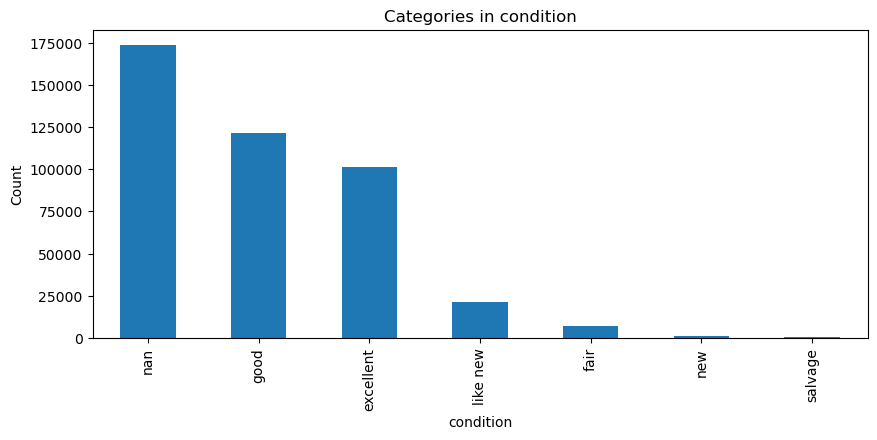

,count,percent
condition,,
NaN,174104,40.79
good,121456,28.45
excellent,101467,23.77
like new,21178,4.96
fair,6769,1.59
new,1305,0.31
salvage,601,0.14


In [851]:
plot_cat_column(data_raw, "condition")

##### Review Distribution of values - cylinders



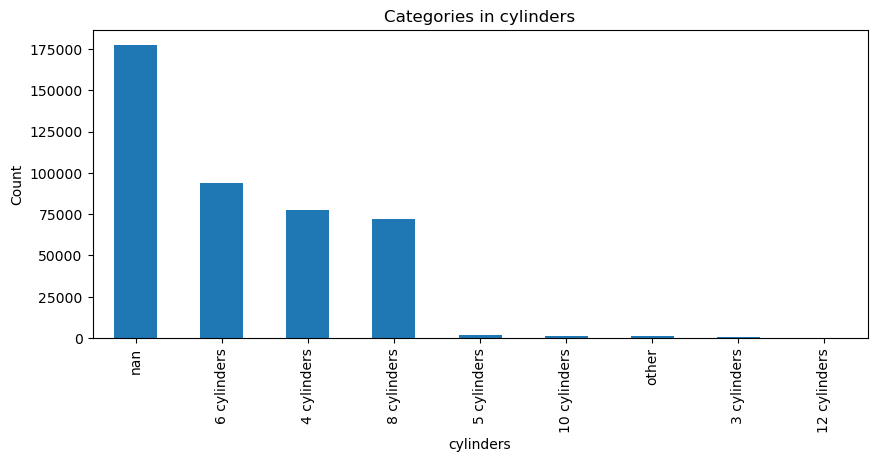

,count,percent
cylinders,,
NaN,177678,41.62
6 cylinders,94169,22.06
4 cylinders,77642,18.19
8 cylinders,72062,16.88
5 cylinders,1712,0.40
10 cylinders,1455,0.34
other,1298,0.30
3 cylinders,655,0.15
12 cylinders,209,0.05


In [852]:
plot_cat_column(data_raw, "cylinders")


##### Review Distribution of values - fuel



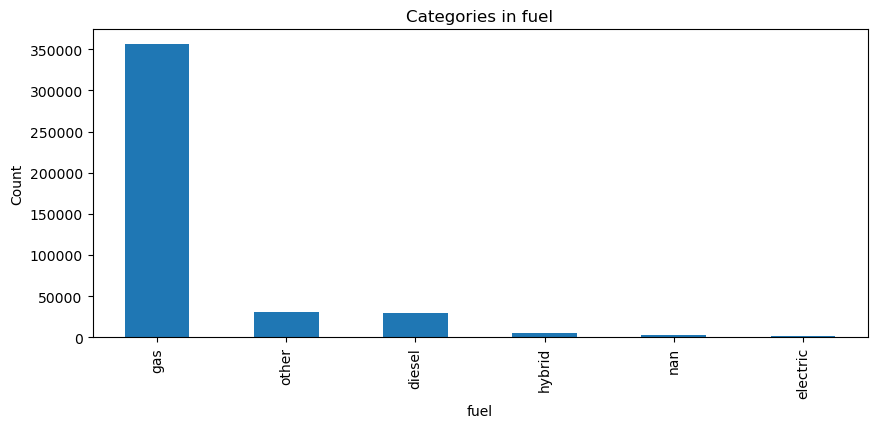

,count,percent
fuel,,
gas,356209,83.44
other,30728,7.20
diesel,30062,7.04
hybrid,5170,1.21
NaN,3013,0.71
electric,1698,0.40


In [853]:
plot_cat_column(data_raw, "fuel")


##### Review Distribution of values - title_status 



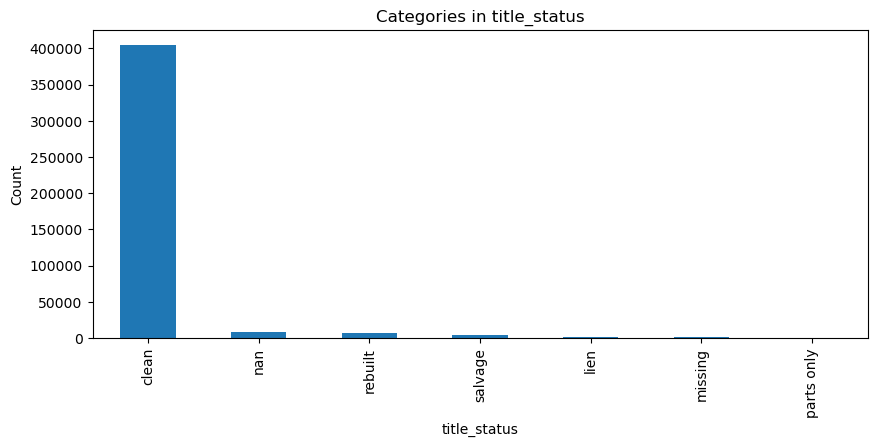

,count,percent
title_status,,
clean,405117,94.90
NaN,8242,1.93
rebuilt,7219,1.69
salvage,3868,0.91
lien,1422,0.33
missing,814,0.19
parts only,198,0.05


In [854]:
plot_cat_column(data_raw, "title_status")



##### Review Distribution of values - transmission 



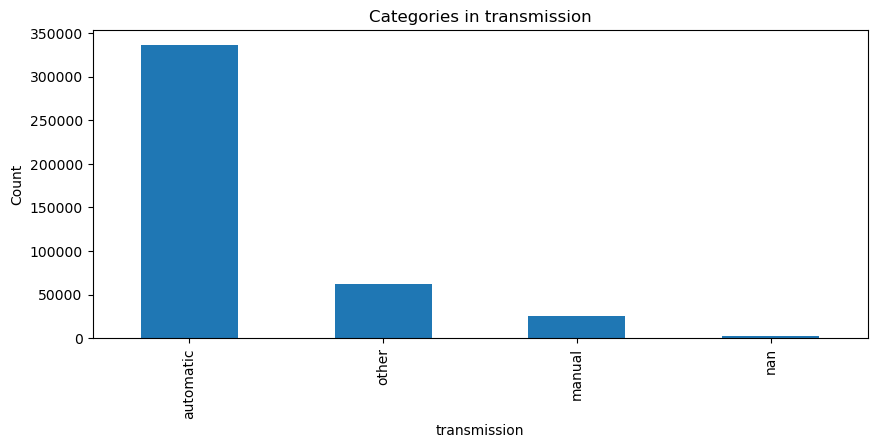

,count,percent
transmission,,
automatic,336524,78.83
other,62682,14.68
manual,25118,5.88
NaN,2556,0.60


In [855]:
plot_cat_column(data_raw, "transmission")


##### Review Distribution of values - drive



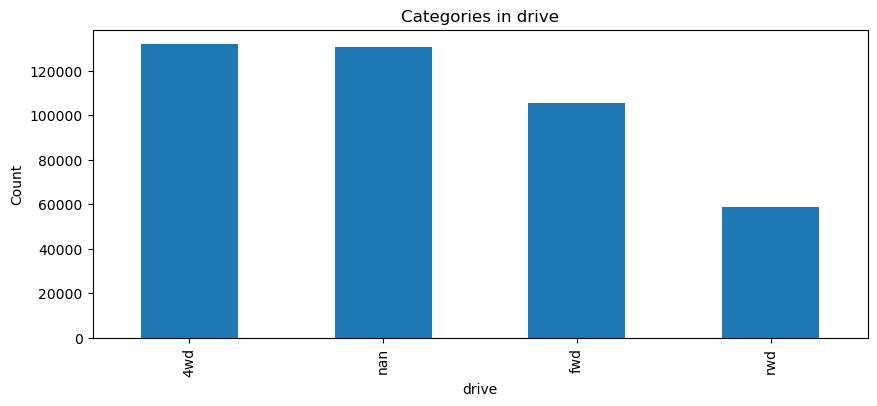

,count,percent
drive,,
4wd,131904,30.90
NaN,130567,30.59
fwd,105517,24.72
rwd,58892,13.80


In [856]:
plot_cat_column(data_raw, "drive")


##### Review Distribution of values - size



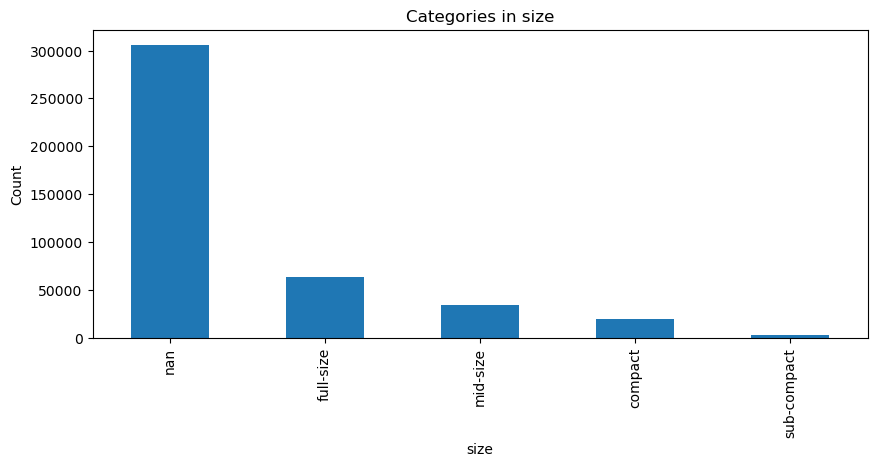

,count,percent
size,,
NaN,306361,71.77
full-size,63465,14.87
mid-size,34476,8.08
compact,19384,4.54
sub-compact,3194,0.75


In [857]:
plot_cat_column(data_raw, "size")


##### Review Distribution of values - type



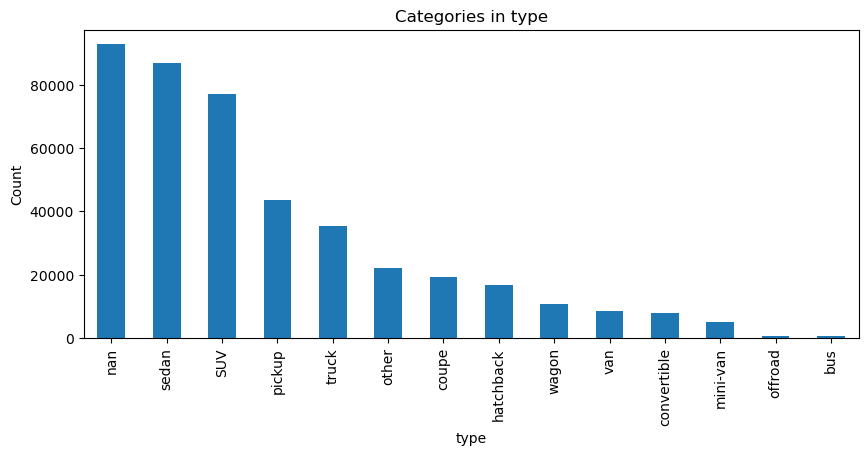

,count,percent
type,,
NaN,92858,21.75
sedan,87056,20.39
SUV,77284,18.10
pickup,43510,10.19
truck,35279,8.26
other,22110,5.18
coupe,19204,4.50
hatchback,16598,3.89
wagon,10751,2.52


In [858]:
plot_cat_column(data_raw, "type")


##### Review Distribution of values - paint_color



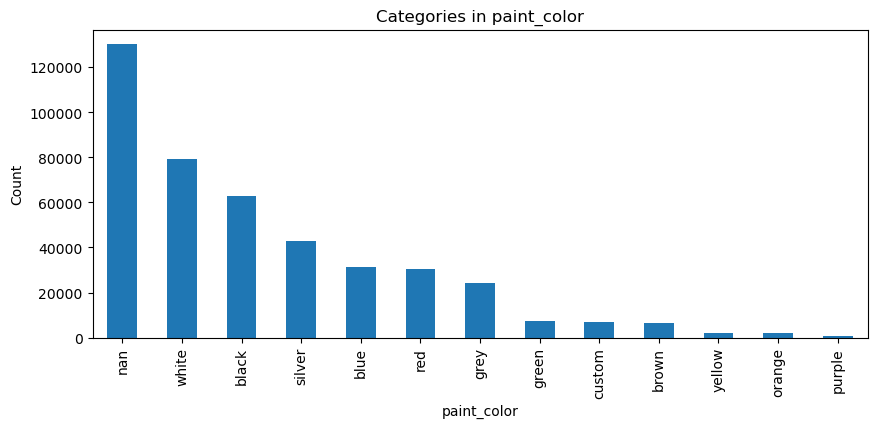

,count,percent
paint_color,,
NaN,130203,30.50
white,79285,18.57
black,62861,14.73
silver,42970,10.07
blue,31223,7.31
red,30473,7.14
grey,24416,5.72
green,7343,1.72
custom,6700,1.57


In [859]:
plot_cat_column(data_raw, "paint_color")


#### Review distribution of data within Numeric columns


In [860]:
def quantile_summary(df, colname, perc_list):
    """
    Return a DataFrame of quantile values for a given column.
    """
    if colname not in df.columns:
        raise ValueError(f"Column '{colname}' not found in DataFrame")
    
    results = []
    for p in perc_list:
        val = df[colname].quantile(p)
        results.append({"Percentile": f"{p*100:.1f}%", "Value": val})
    
    return pd.DataFrame(results)

##### Review distribution of Year attribute

- Key Observation:
    - There are some exceedingly old cars in the sample (min = 1900).
    - Antique cars have a very different market dynamic than the standard used car market.  Those cars that are so old that, except for specialty antique car dealers, would never be found on a normal used car lot should be excluded from the sample, else we risk skewing the data analysis.


,Percentile,Value
0,1.0%,1967.0
1,2.0%,1980.0
2,5.0%,1998.0
3,10.0%,2003.0


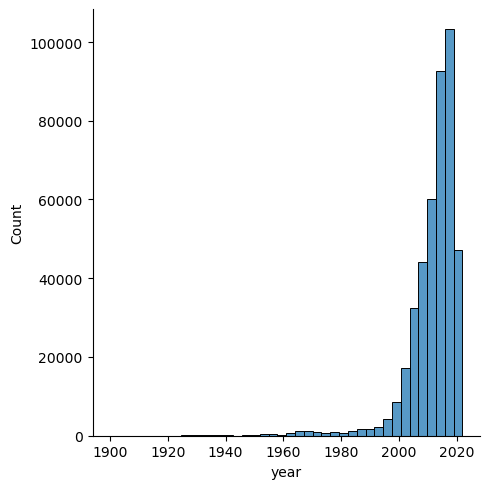

In [861]:
sns.displot(data_raw, x="year", bins=40)

percents = [.01, .02, .05, .1]
quantile_summary(data_raw, 'year', percents)


##### Review distribution of Odometer attribute

- Key Observation:
    - There are some cars with extremely high odomter readings.
    - Similar to the analysis of year above, those cars with very high odomoter readings would not normally be found on the typical used car lot, which tend to feature later model year cars.  Those records with exceedingly high odometer readings should be excluded from the sample, else we risk skewing the data analysis by these outliers.


,Percentile,Value
0,90.0%,177377.10
1,95.0%,204000.00
2,98.0%,243262.42
3,99.0%,280000.00


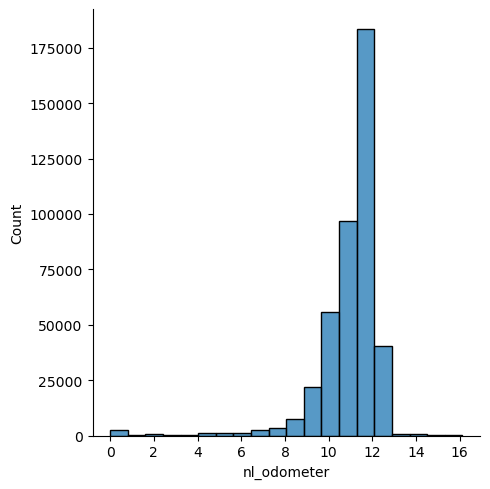

In [862]:

chart_data =  pd.DataFrame(np.log(data_raw['odometer']))
chart_data.columns = ['nl_odometer']
sns.displot(chart_data, x="nl_odometer", bins=20)

percents = [.9, .95, .98, .99]
quantile_summary(data_raw, 'odometer', percents)


##### Review distribution of Price attribute

- Key Observation:
    - There are some cars with extremely high prices.
    - Similar to the analysis of year above, those cars with very high prices will tend to skew the analysis relative to the more common price range for vehicles on a used car lot.  These high priced outliers should be excluded from the data analysis. 
 

,Percentile,Value
0,1.0%,2.00
1,2.0%,206.58
2,5.0%,6318.00
3,10.0%,14939.00
4,15.0%,22693.00
5,20.0%,30000.00
6,25.0%,37704.00
7,90.0%,177377.10
8,95.0%,204000.00
9,98.0%,243262.42


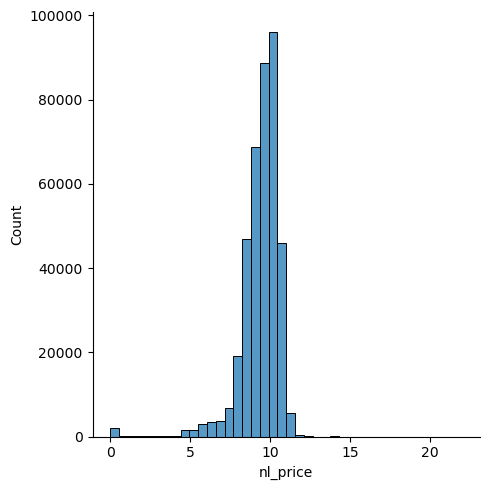

In [863]:
chart_data =  pd.DataFrame(np.log(data_raw['price']))
chart_data.columns = ['nl_price']

sns.displot(chart_data, x="nl_price", bins=40)

percents = [.01, .02, .05, .1, .15, .2, .25, .9, .95, .98, .99,.999]
quantile_summary(data_raw, 'odometer', percents)


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Drop extraneous columns

- id and VIN are individual identifiers for each vehicle and are thus redundant with the dataframe index itself.
- Region is redundant with state (both indicate the geographic location), but region features far more discrete data points.
- Model possesses 29650 unique values and likewise logically overlaps with manufacturer.  There will be too few data points per model to make this relevant.

Drop these 4 columns from the data
* id
* VIN
* region
* model
  

In [864]:
## drop irrelevant columns
print(data_raw.shape)
data_raw.drop(['id','VIN','region','model'], axis = 1, inplace = True)
print(data_raw.shape)


(426880, 18)
(426880, 14)


#### Drop rows with na values

For a portion of the data attributes where the na count is a small %, we can drop these rows without significantly impacting the size of our data sample.

As shown below, this consists of the attributes:
- year
- manufacturer
- fuel
- odometer
- title_status
- transmission

In [865]:
isNull = pd.DataFrame(pd.concat([data_raw.isna().sum(), (data_raw.isna().sum()/data_raw.shape[0]*100)], axis=1) )
isNull.columns = ['nullCount','nullPct']

isNull[isNull['nullPct'] < 5] 


,nullCount,nullPct
price,0,0.000000
year,1205,0.282281
manufacturer,17646,4.133714
fuel,3013,0.705819
odometer,4400,1.030735
title_status,8242,1.930753
transmission,2556,0.598763
state,0,0.000000


In [866]:
data_cleaned = data_raw.dropna(subset=['year','manufacturer',  'fuel', 'odometer', 'title_status', 'transmission'])

In [867]:
isNull_clean = pd.DataFrame(pd.concat([data_cleaned.isna().sum(), (data_cleaned.isna().sum()/data_cleaned.shape[0]*100)], axis=1) )
isNull_clean.columns = ['nullCount','nullPct']
isNull_clean

,nullCount,nullPct
price,0,0.000000
year,0,0.000000
manufacturer,0,0.000000
condition,160167,40.574185
cylinders,163905,41.521111
fuel,0,0.000000
odometer,0,0.000000
title_status,0,0.000000
transmission,0,0.000000
drive,117309,29.717214


In [868]:
print("Raw data count:",data_raw.shape[0])
print("Clean data count:",data_cleaned.shape[0])
dropped_pct = (data_raw.shape[0]-data_cleaned.shape[0])*100/data_raw.shape[0]

print("Drop na removed", f"{dropped_pct:.2f}", "percent of the data")

Raw data count: 426880
Clean data count: 394751
Drop na removed 7.53 percent of the data


#### Replace na values with "unknown" string

In other cases, some of the attributes have an na count that is large enough that we cannot simply drop all these rows.  This would risk losing a substantial portion of our test data.  As such, we will replace these na values with the string value "unknown".

This applies to the following attributes:
- condition
- cylinders
- drive	
- size
- type
- paint_color


In [869]:
## replace na with "unknown" string value
data_cleaned['condition'] = data_cleaned['condition'].fillna('unknown')
data_cleaned['cylinders'] = data_cleaned['cylinders'].fillna('unknown')
data_cleaned['drive'] = data_cleaned['drive'].fillna('unknown')
data_cleaned['size'] = data_cleaned['size'].fillna('unknown')
data_cleaned['type'] = data_cleaned['type'].fillna('unknown')
data_cleaned['paint_color'] = data_cleaned['paint_color'].fillna('unknown')

total_nan_count = data_cleaned.isna().sum().sum()
print(total_nan_count)

0


#### Regroup categorical data

In some cases, the categorical data contains values which appear in a very small % of the rows.  It will be more efficient to re-group some of this data into a larger category to reduce the # of columns that will be generated by OneHotEncoder and thereby reduce the processing time for fitting the model.

This applies to the following attributes:
- paint_color
    - The more uncommon paint colors can be re-grouped as "other".  We don't need to run regression on purple vehicles.
- title_status
    - 94% of the cases the title is clean.  This can be changed to a boolean column isCleanTitle true/false.
- fuel
    - There is a small count of electric cars.  This can be grouped together with hybrid.
- type
    - Some of the very small types (e.g. bus) can simply be removed.  In other cases, categories can be regrouped into a larger category (e.g. van + minivan).



In [870]:
## Change labels for unusual paint colors to a general "other" category
data_cleaned.loc[data_cleaned['paint_color'] == 'green', 'paint_color'] = 'other'
data_cleaned.loc[data_cleaned['paint_color'] == 'custom', 'paint_color'] = 'other'
data_cleaned.loc[data_cleaned['paint_color'] == 'brown', 'paint_color'] = 'other'
data_cleaned.loc[data_cleaned['paint_color'] == 'yellow', 'paint_color'] = 'other'
data_cleaned.loc[data_cleaned['paint_color'] == 'orange', 'paint_color'] = 'other'
data_cleaned.loc[data_cleaned['paint_color'] == 'purple', 'paint_color'] = 'other'

print(data_cleaned['paint_color'].value_counts())

paint_color
unknown    115383
white       73891
black       59973
silver      41025
blue        29517
red         28339
other       23385
grey        23238
Name: count, dtype: int64


In [871]:
## Replace title_status column with a boolean isCleanTitle column
data_cleaned['isCleanTitle'] = False
data_cleaned['isCleanTitle'] = (data_cleaned['title_status'] == "clean") 
data_cleaned.drop(['title_status'], axis = 1, inplace = True)

data_cleaned['isCleanTitle'] = data_cleaned['isCleanTitle'].astype(int)

print(data_cleaned['isCleanTitle'].value_counts())


isCleanTitle
1    381984
0     12767
Name: count, dtype: int64


In [872]:
## Regroup hyrbrid and electric into a single fuel classification

data_cleaned.loc[data_cleaned['fuel'] == 'hybrid', 'fuel'] = 'hybrid/electric'
data_cleaned.loc[data_cleaned['fuel'] == 'electric', 'fuel'] = 'hybrid/electric'

print(data_cleaned['fuel'].value_counts())


fuel
gas                333378
other               29136
diesel              25687
hybrid/electric      6550
Name: count, dtype: int64


In [873]:
## Group together related types into a common classification
data_cleaned.loc[data_cleaned['type'] == 'coupe', 'type'] = 'coupe/convertible'
data_cleaned.loc[data_cleaned['type'] == 'convertible', 'type'] = 'coupe/convertible'

data_cleaned.loc[data_cleaned['type'] == 'van', 'type'] = 'van/mini-van'
data_cleaned.loc[data_cleaned['type'] == 'mini-van', 'type'] = 'van/mini-van'

data_cleaned.loc[data_cleaned['type'] == 'wagon', 'type'] = 'wagon/hatchback'
data_cleaned.loc[data_cleaned['type'] == 'hatchback', 'type'] = 'wagon/hatchback'

print(data_cleaned['type'].value_counts())


type
unknown              84925
sedan                81243
SUV                  71975
pickup               41663
truck                32408
wagon/hatchback      25131
coupe/convertible    24193
other                20164
van/mini-van         12161
offroad                571
bus                    317
Name: count, dtype: int64


In [874]:
## Drop rows for type = 'offroad' or 'bus'.  These car types are not relevant to the average used car dealer. 
## Only a small number of samples will be lost by removing them from the data set. 

print("Shape before drop:", data_cleaned.shape)

data_cleaned = data_cleaned.drop(data_cleaned[data_cleaned['type'] == "offroad"].index)
data_cleaned = data_cleaned.drop(data_cleaned[data_cleaned['type'] == "bus"].index)

print("Shape after drop:", data_cleaned.shape)

Shape before drop: (394751, 14)
Shape after drop: (393863, 14)


#### Drop data with numeric outliers

In some cases, the numeric data contains extreme outliers (year, odometer, price) which are not representative of the typical vehicle found on a US used car lot.  This extreme data should be removed from the data set to avoid skewing the analysis.

The thresholds below are subjective, but represent "round" values that can easily be communicated to business leaders.  

This applies to the following attributes:
- year
    - We will filter the data set for only those a max of 20 years old.
    - The year max is 2022, so we will filter to include only model years 2003 and higher.
- odometer
    - In the raw data above, the 95th Percentile for odometer was calculated as 204000.
    - We will round down to 200000, and only includes vehicles below this threshold.
- price
    - In the raw data, the 99th Percentile was found at 66995.
    - The 99.9th Percentile at 120000.
    - We will only include vehicles at a price of 100000 or lower.
    - Likewise, we will only include vehicles at a price of 2000 or higher.
    - Again, these round figure make it easier to communicate the boundary cases to business leaders.


In [875]:
count_before_drop = data_cleaned.shape[0]
describe_before = data_cleaned.describe()



print(describe_before)
count_before_drop



              price           year      odometer   isCleanTitle
count  3.938630e+05  393863.000000  3.938630e+05  393863.000000
mean   7.943344e+04    2011.472025  9.684534e+04       0.967717
std    1.267956e+07       8.989067  2.005962e+05       0.176750
min    0.000000e+00    1900.000000  0.000000e+00       0.000000
25%    5.995000e+03    2008.000000  3.800000e+04       1.000000
50%    1.399500e+04    2014.000000  8.582000e+04       1.000000
75%    2.659000e+04    2017.000000  1.335000e+05       1.000000
max    3.736929e+09    2022.000000  1.000000e+07       1.000000


393863

In [876]:

data_cleaned = data_cleaned[data_cleaned['price'] <= 100000]
data_cleaned = data_cleaned[data_cleaned['price'] >= 2000]
data_cleaned = data_cleaned[data_cleaned['year'] >= 2003]
data_cleaned = data_cleaned[data_cleaned['odometer'] <= 200000]


print(data_cleaned.describe())

before_price_std = describe_before.loc['std','price']
after_price_std = data_cleaned.describe().loc['std','price']
pctchange_price_std = -(before_price_std - after_price_std)/before_price_std*100

before_year_std = describe_before.loc['std','year']
after_year_std = data_cleaned.describe().loc['std','year']
pctchange_year_std = -(before_year_std - after_year_std)/before_year_std*100

before_odo_std = describe_before.loc['std','odometer']
after_odo_std = data_cleaned.describe().loc['std','odometer']
pctchange_odo_std = -(before_odo_std - after_odo_std)/before_odo_std*100

count_after_drop = data_cleaned.shape[0]

print(pctchange_price_std)
print(pctchange_year_std )
print(pctchange_odo_std)

print((count_after_drop - count_before_drop) / count_before_drop *100)
print(count_before_drop)
print(count_after_drop)

               price           year       odometer   isCleanTitle
count  305125.000000  305125.000000  305125.000000  305125.000000
mean    20927.367115    2013.585740   82530.856007       0.966512
std     14124.969971       4.453385   53114.685634       0.179907
min      2000.000000    2003.000000       0.000000       0.000000
25%      9495.000000    2011.000000   34552.000000       1.000000
50%     17990.000000    2014.000000   79696.000000       1.000000
75%     29855.000000    2017.000000  124089.000000       1.000000
max    100000.000000    2022.000000  200000.000000       1.000000
-99.88860043322704
-50.45775879997034
-73.52158629793696
-22.530169119719293
393863
305125


#### Convert year to a car_age values

- Will make the results more generic, instead of with reference to the specific calendar years in the source data.
- Max year in the data set is 2022, so we will assume used cars in that year are 1 year old or less.


In [877]:
data_cleaned['car_age'] = 2023 - data_cleaned['year']
data_cleaned.drop(['year'], axis = 1, inplace = True)

#### Add Mile per Year as Ratio attribute

- Binning mileage into 10K buckets
- Replace odometer column with odometer_bin feature representation


In [878]:
data_cleaned['miles_per_year'] = data_cleaned['odometer']/data_cleaned['car_age']  

#### Create Category Bins for Odometer attribute

- Binning mileage into 10K buckets
- Replace odometer column with odometer_bin feature representation


In [879]:
def bin_mileage(df, colname="odometer", bin_size=10000):
    
    # Define bin edges from 0 up to max mileage
    max_val = int(np.nanmax(df[colname]))
    bins = list(range(0, max_val + bin_size, bin_size))
    
    # Create labels like "0-9999", "10000-19999", ...
    labels = [f"{i}-{i+bin_size-1}" for i in bins[:-1]]
    
    df[f"{colname}_bin"] = pd.cut(df[colname], bins=bins, labels=labels, include_lowest=True)
    return df

data_cleaned = bin_mileage(data_cleaned, "odometer", bin_size=10000)
data_cleaned.drop(['odometer'], axis = 1, inplace = True)

#### Create bins to re-group the cylinder count into fewer categories

- 4, 6, and 8 are the most common values for this attribute
- corresponds roughly to small, med, large engine power


In [880]:
is8orMore = (data_cleaned['cylinders'] == "10 cylinders") | (data_cleaned['cylinders'] == "12 cylinders") | (data_cleaned['cylinders'] == "8 cylinders")
data_cleaned.loc[is8orMore, 'cylinders'] = "8 or more"

is5or6 = (data_cleaned['cylinders'] == "5 cylinders") | (data_cleaned['cylinders'] == "6 cylinders")
data_cleaned.loc[is5or6, 'cylinders'] = "5 or 6"

is4orLess = (data_cleaned['cylinders'] == "3 cylinders") | (data_cleaned['cylinders'] == "4 cylinders")
data_cleaned.loc[is4orLess, 'cylinders'] = "4 or less"

data_cleaned['cylinders'].value_counts()

cylinders
unknown      129939
5 or 6        70082
4 or less     57982
8 or more     46499
other           623
Name: count, dtype: int64

#### Convert object to category data types 




In [881]:
for col in data_cleaned.select_dtypes(include='object').columns:
     data_cleaned[col] = data_cleaned[col].astype('category')


#### Create deep copy of final clean data set for usage in modeling


In [882]:
data_final =data_cleaned.copy(deep=True)

print(data_final.info())
print(data_final.describe())
data_final.head()


<class 'pandas.core.frame.DataFrame'>
Index: 305125 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   price           305125 non-null  int64   
 1   manufacturer    305125 non-null  category
 2   condition       305125 non-null  category
 3   cylinders       305125 non-null  category
 4   fuel            305125 non-null  category
 5   transmission    305125 non-null  category
 6   drive           305125 non-null  category
 7   size            305125 non-null  category
 8   type            305125 non-null  category
 9   paint_color     305125 non-null  category
 10  state           305125 non-null  category
 11  isCleanTitle    305125 non-null  int64   
 12  car_age         305125 non-null  float64 
 13  miles_per_year  305125 non-null  float64 
 14  odometer_bin    305125 non-null  category
dtypes: category(11), float64(2), int64(2)
memory usage: 14.8 MB
None
               price   i

,price,manufacturer,condition,cylinders,fuel,transmission,drive,size,type,paint_color,state,isCleanTitle,car_age,miles_per_year,odometer_bin
27,33590,gmc,good,8 or more,gas,other,unknown,unknown,pickup,white,al,1,9.0,6435.888889,50000-59999
28,22590,chevrolet,good,8 or more,gas,other,unknown,unknown,pickup,blue,al,1,13.0,5479.153846,70000-79999
29,39590,chevrolet,good,8 or more,gas,other,unknown,unknown,pickup,red,al,1,3.0,6386.666667,10000-19999
30,30990,toyota,good,8 or more,gas,other,unknown,unknown,pickup,red,al,1,6.0,6854.000000,40000-49999
31,15000,ford,excellent,5 or 6,gas,automatic,rwd,full-size,truck,black,al,1,10.0,12800.000000,120000-129999


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Split the data train/test


In [883]:
# Target: log(price)
y = np.log(data_final['price'].copy())

# Feature set: drop target 
X = data_final.copy()
X.drop(['price'], axis = 1, inplace = True)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#### Model 1 - Simple Multiple Regression

* OHE for categorical data
* Ordinal Encoder for odometer_bins, since these are strictly ordered
* StandardScalar for car_age (the only numeric value)

* set Target as log(price)


##### Segment the columns and define the preprocess transformer



In [884]:
# Identify nominal category columns
cat_nominal = X.select_dtypes(include=['object', 'category']).columns.tolist()
cat_nominal.remove('odometer_bin') 

# Numeric columns: 
scale_numeric = ['car_age','miles_per_year']
pass_numeric = ['isCleanTitle']  

# Separate odometer_bin from other categoricals, since has ordinal order
odo_bin_col = ['odometer_bin']

ord_categories =  [['0-9999',
  '10000-19999',
  '20000-29999',
  '30000-39999',
  '40000-49999',
  '50000-59999',
  '60000-69999',
  '70000-79999',
  '80000-89999',
  '90000-99999',
  '100000-109999',
  '110000-119999',
  '120000-129999',
  '130000-139999',
  '140000-149999',
  '150000-159999',
  '160000-169999',
  '170000-179999',
  '180000-189999',
  '190000-199999']]


In [885]:
# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        # Ordinal for odometer_bin
        ('ord_odo', OrdinalEncoder(categories=ord_categories,
                                   handle_unknown='use_encoded_value',
                                   unknown_value=-1), odo_bin_col),
        # OneHot for all other categoricals
        ('ohe_cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_nominal),
        # Scale car_age
        ('scale_age', StandardScaler(), scale_numeric),
        # Pass-through other numerics unchanged
       ('num_passthrough', 'passthrough', pass_numeric),
    ],
    remainder='drop'
)



##### Define Pipeline and fit model



In [886]:
# Model: plain multiple linear regression (no higher-order features)
model = LinearRegression()

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', model)
])

# Fit
pipe.fit(X_train, y_train)



Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('ord_odo',
                                                  OrdinalEncoder(categories=[['0-9999',
                                                                              '10000-19999',
                                                                              '20000-29999',
                                                                              '30000-39999',
                                                                              '40000-49999',
                                                                              '50000-59999',
                                                                              '60000-69999',
                                                                              '70000-79999',
                                                                              '80000-89999',
                                                                              '90000-99999',
                                                                              '100000-109999',
                                                                              '110000-119999',
                                                                              '120000-129999',
                                                                              '130000-139999',
                                                                              '140000-149999',
                                                                              '150000-159999',
                                                                              '160000-169999',
                                                                              '170000-...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['odometer_bin']),
                                                 ('ohe_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('scale_age', StandardScaler(),
                                                  ['car_age',
                                                   'miles_per_year']),
                                                 ('num_passthrough',
                                                  'passthrough',
                                                  ['isCleanTitle'])])),
                ('model', LinearRegression())])

##### Find MSE



In [887]:

# Evaluate (MSE on log-price target)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test,  y_pred_test)

print(f"Train MSE (log-price): {mse_train:.6f}")
print(f"Test  MSE (log-price): {mse_test:.6f}")


# Convert log-scale y and preds back to dollars
y_train_USD = np.exp(y_train)
y_test_USD  = np.exp(y_test)
y_pred_train_USD = np.exp(y_pred_train)
y_pred_test_USD  = np.exp(y_pred_test)

# Dollar-scale MSE (units: dollars^2)
mse_train_dollars = mean_squared_error(y_train_USD, y_pred_train_USD)
mse_test_dollars  = mean_squared_error(y_test_USD,  y_pred_test_USD)

# Dollar-scale RMSE (units: dollars)
rmse_train_dollars = np.sqrt(mse_train_dollars)
rmse_test_dollars  = np.sqrt(mse_test_dollars)

print(f"MSE (train, $^2): {mse_train_dollars:,.0f}")  ## 55,087,046
print(f"MSE (test,  $^2): {mse_test_dollars:,.0f}")  ## 55,276,316
print(f"RMSE (train, $):  {rmse_train_dollars:,.0f}") # 7,422     #7371    #7346
print(f"RMSE (test,  $):  {rmse_test_dollars:,.0f}")  # 7,435     #7386    #7347

Train MSE (log-price): 0.113493
Test  MSE (log-price): 0.114944
MSE (train, $^2): 53,956,624
MSE (test,  $^2): 53,983,208
RMSE (train, $):  7,346
RMSE (test,  $):  7,347


In [888]:
bestmodel = pd.DataFrame({
    "Name": ["Model_1"],
    "MSE(log-price)": [mse_test]
})

bestmodel

,Name,MSE(log-price)
0,Model_1,0.114944


##### Examine Model coefficients



In [889]:
coef_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature   156 non-null    object 
 1   coef      156 non-null    float64
 2   abs_coef  156 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.8+ KB


In [890]:
lin = pipe.named_steps["model"]
pre = pipe.named_steps["prep"]

# Feature names after ColumnTransformer
try:
    feature_names = pre.get_feature_names_out()
except TypeError:
    feature_names = pre.get_feature_names_out(input_features=X.columns)

coef = lin.coef_
intercept = lin.intercept_

coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()

# Top effects by magnitude (on log-price scale)
coef_top = coef_df.sort_values("abs_coef", ascending=False)
display(coef_top.head(25))



,feature,coef,abs_coef
3,ohe_cat__manufacturer_aston-martin,1.109918,1.109918
11,ohe_cat__manufacturer_ferrari,0.611524,0.611524
37,ohe_cat__manufacturer_tesla,0.558565,0.558565
32,ohe_cat__manufacturer_porsche,0.555269,0.555269
12,ohe_cat__manufacturer_fiat,-0.459821,0.459821
53,ohe_cat__fuel_diesel,0.428223,0.428223
27,ohe_cat__manufacturer_mercury,-0.414012,0.414012
29,ohe_cat__manufacturer_mitsubishi,-0.373775,0.373775
42,ohe_cat__condition_fair,-0.372266,0.372266
137,scale_age__car_age,-0.338037,0.338037


In [891]:
coef_df[coef_df['feature'].str.contains('condition')]

,feature,coef,abs_coef
41,ohe_cat__condition_excellent,0.137884,0.137884
42,ohe_cat__condition_fair,-0.372266,0.372266
43,ohe_cat__condition_good,0.079925,0.079925
44,ohe_cat__condition_like new,0.120606,0.120606
45,ohe_cat__condition_new,0.153602,0.153602
46,ohe_cat__condition_salvage,-0.299125,0.299125
47,ohe_cat__condition_unknown,0.179373,0.179373


In [892]:
coef_df[coef_df['feature'].str.contains('cylinders')]

,feature,coef,abs_coef
48,ohe_cat__cylinders_4 or less,-0.174191,0.174191
49,ohe_cat__cylinders_5 or 6,0.016916,0.016916
50,ohe_cat__cylinders_8 or more,0.236423,0.236423
51,ohe_cat__cylinders_other,-0.085393,0.085393
52,ohe_cat__cylinders_unknown,0.006246,0.006246


In [893]:
coef_df[coef_df['feature'].str.contains('fuel')]

,feature,coef,abs_coef
53,ohe_cat__fuel_diesel,0.428223,0.428223
54,ohe_cat__fuel_gas,-0.162082,0.162082
55,ohe_cat__fuel_hybrid/electric,-0.206863,0.206863
56,ohe_cat__fuel_other,-0.059278,0.059278


In [894]:
coef_df[coef_df['feature'].str.contains('transmission')]

,feature,coef,abs_coef
57,ohe_cat__transmission_automatic,-0.046168,0.046168
58,ohe_cat__transmission_manual,0.034114,0.034114
59,ohe_cat__transmission_other,0.012054,0.012054


In [895]:
coef_df[coef_df['feature'].str.contains('drive')]

,feature,coef,abs_coef
60,ohe_cat__drive_4wd,0.118028,0.118028
61,ohe_cat__drive_fwd,-0.134785,0.134785
62,ohe_cat__drive_rwd,0.077325,0.077325
63,ohe_cat__drive_unknown,-0.060568,0.060568


In [896]:
coef_df[coef_df['feature'].str.contains('size')]

,feature,coef,abs_coef
64,ohe_cat__size_compact,-0.039493,0.039493
65,ohe_cat__size_full-size,0.018218,0.018218
66,ohe_cat__size_mid-size,0.014662,0.014662
67,ohe_cat__size_sub-compact,-0.057349,0.057349
68,ohe_cat__size_unknown,0.063963,0.063963


In [897]:
coef_df[coef_df['feature'].str.contains('type')]

,feature,coef,abs_coef
69,ohe_cat__type_SUV,-0.045876,0.045876
70,ohe_cat__type_coupe/convertible,0.094147,0.094147
71,ohe_cat__type_other,0.091296,0.091296
72,ohe_cat__type_pickup,0.136305,0.136305
73,ohe_cat__type_sedan,-0.161031,0.161031
74,ohe_cat__type_truck,0.147713,0.147713
75,ohe_cat__type_unknown,-0.079851,0.079851
76,ohe_cat__type_van/mini-van,-0.031681,0.031681
77,ohe_cat__type_wagon/hatchback,-0.151022,0.151022


In [898]:
coef_df[coef_df['feature'].str.contains('paint_color')]

,feature,coef,abs_coef
78,ohe_cat__paint_color_black,0.017646,0.017646
79,ohe_cat__paint_color_blue,-0.010187,0.010187
80,ohe_cat__paint_color_grey,-0.012293,0.012293
81,ohe_cat__paint_color_other,0.025518,0.025518
82,ohe_cat__paint_color_red,0.005639,0.005639
83,ohe_cat__paint_color_silver,-0.019724,0.019724
84,ohe_cat__paint_color_unknown,-0.023133,0.023133
85,ohe_cat__paint_color_white,0.016534,0.016534


In [899]:
coef_df[coef_df['feature'].str.contains('odometer_bin|isCleanTitle|car_age|miles_per_year')]

,feature,coef,abs_coef
0,ord_odo__odometer_bin,-0.045345,0.045345
137,scale_age__car_age,-0.338037,0.338037
138,scale_age__miles_per_year,0.043442,0.043442
139,num_passthrough__isCleanTitle,0.271759,0.271759


In [900]:
print(coef_df[coef_df['feature'].str.contains('state')].shape[0])
print(coef_df[coef_df['feature'].str.contains('manufacturer')].shape[0])

51
40


#### Model 2 - Higher Order Multiple Regression

* Use PolynomialFeatures to test for higher order features from degree 1-9
* Identify the best model by comparing the resulting test MSE for each run


##### Build the pipeline to support PolynomialFeatures

In [901]:

X['miles_per_year'] = pd.to_numeric(X['miles_per_year'], errors='coerce')

scale_numeric = ['car_age', 'miles_per_year']
pass_numeric = ['isCleanTitle']  

# Numeric branch: scale numerics, then PolynomialFeatures
num_pre = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_numeric),
        ('num_passthrough', 'passthrough', pass_numeric),
    ],
    remainder='drop'
)

num_poly = Pipeline(steps=[
    ('prep', num_pre),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))  # degree will be tuned below
])

# Ordinal branch: odometer_bin -> OrdinalEncoder
ord_branch = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ord_categories,
                               handle_unknown='use_encoded_value',
                               unknown_value=-1),
         odo_bin_col)
    ],
    remainder='drop'
)

# Categorical branch: OneHotEncode all other categoricals
cat_branch = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_nominal)
    ],
    remainder='drop'
)

# Combine branches
features = FeatureUnion(transformer_list=[
    ('num', num_poly),
    ('ord', ord_branch),
    ('cat', cat_branch)
])

# Full model pipeline
pipe_poly = Pipeline(steps=[
    ('features', features),
    ('model', LinearRegression())
])

pipe_poly

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('num',
                                                 Pipeline(steps=[('prep',
                                                                  ColumnTransformer(transformers=[('scale',
                                                                                                   StandardScaler(),
                                                                                                   ['car_age',
                                                                                                    'miles_per_year']),
                                                                                                  ('num_passthrough',
                                                                                                   'passthrough',
                                                                                                   ['isCleanTitle'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('ord',
                                                 ColumnTransformer(transformers=[('ord',
                                                                                  OrdinalEncod...
                                                                                                              '170000-179999',
                                                                                                              '180000-189999',
                                                                                                              '190000-199999']],
                                                                                                 handle_unknown='use_encoded_value',
                                                                                                 unknown_value=-1),
                                                                                  ['odometer_bin'])])),
                                                ('cat',
                                                 ColumnTransformer(transformers=[('ohe',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['manufacturer',
                                                                                   'condition',
                                                                                   'cylinders',
                                                                                   'fuel',
                                                                                   'transmission',
                                                                                   'drive',
                                                                                   'size',
                                                                                   'type',
                                                                                   'paint_color',
                                                                                   'state'])]))])),
                ('model', LinearRegression())])

##### Fit models of degree 1 - 9

In [902]:
# Loop degrees and report MSE (log scale)
results = []
for degree in range(1, 10):
    # Set polynomial degree
    pipe_poly.set_params(features__num__poly__degree=degree)

    # Fit
    pipe_poly.fit(X_train, y_train)

    # Predict
    y_pred_train = pipe_poly.predict(X_train)
    y_pred_test  = pipe_poly.predict(X_test)

    # MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test,  y_pred_test)

    results.append((degree, mse_train, mse_test))

# Display results
print("Degree | Train MSE (log) | Test MSE (log)")
for deg, mtr, mts in results:
    print(f"{deg:>6} | {mtr:.10f}       | {mts:.10f}")   # 3 | 0.1123852384       | 0.1140641028

Degree | Train MSE (log) | Test MSE (log)
     1 | 0.1134926773       | 0.1149437686
     2 | 0.1129499967       | 0.1145603123
     3 | 0.1123852384       | 0.1140641028
     4 | 0.1127800041       | 0.1142420850
     5 | 0.1468948358       | 0.1467961058
     6 | 0.4714890454       | 0.4741286202
     7 | 0.5577395935       | 0.5601691513
     8 | 0.5577417309       | 0.5601702027
     9 | 0.5577440792       | 0.5601728757


##### Identify best hyperparameter (degree)

In [903]:
# results is a list of tuples: (degree, mse_train, mse_test)
res_df = pd.DataFrame(results, columns=["degree", "mse_train_log", "mse_test_log"])

# Identify best degree by lowest Test MSE (log scale)
best_idx = res_df["mse_test_log"].idxmin()
best_row = res_df.loc[best_idx]
best_degree = int(best_row["degree"])

print("Best degree by Test MSE (log):", best_degree)
print(best_row)


Best degree by Test MSE (log): 3
degree           3.000000
mse_train_log    0.112385
mse_test_log     0.114064
Name: 2, dtype: float64


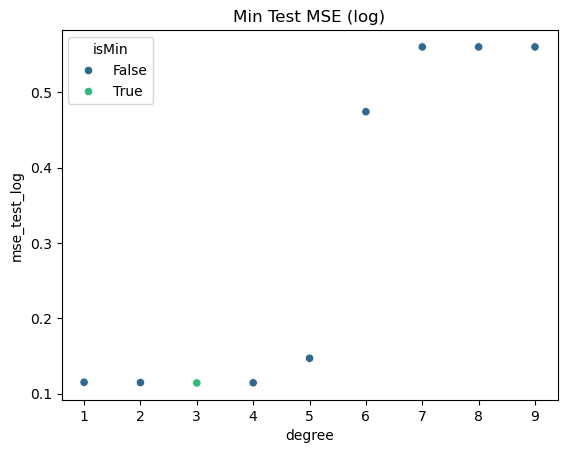

In [904]:
res_df['isMin'] = False
res_df.loc[best_idx, 'isMin'] = True

sns.scatterplot(data=res_df, x='degree', y='mse_test_log', hue='isMin', palette='viridis')
plt.title("Min Test MSE (log)")
plt.show()

##### Refit model using best degree identifed to extract coefficients

In [905]:
# 1) Refit pipe_poly at the best degree found earlier
pipe_poly.set_params(features__num__poly__degree=best_degree)
pipe_poly.fit(X_train, y_train)

# 2) Gather feature names from each branch, in pipeline order
feat_union = pipe_poly.named_steps["features"]
tmap = dict(feat_union.transformer_list)

# --- Numeric (with PolynomialFeatures)
num_pipe = tmap["num"]                          # Pipeline(prep -> poly)
num_prep = num_pipe.named_steps["prep"]         # ColumnTransformer
num_poly = num_pipe.named_steps["poly"]         # PolynomialFeatures

num_base_names = num_prep.get_feature_names_out()
num_poly_names = num_poly.get_feature_names_out(num_base_names)

# --- Ordinal (odometer_bin via OrdinalEncoder)
ord_ct = tmap["ord"]                            # ColumnTransformer
ord_names = ord_ct.get_feature_names_out()

# --- Nominal categoricals (OneHotEncoder)
cat_ct = tmap["cat"]                            # ColumnTransformer
cat_names = cat_ct.get_feature_names_out()

# Concatenate in the same order as FeatureUnion: num -> ord -> cat
all_feature_names = np.concatenate([num_poly_names, ord_names, cat_names])

# 3) Pull coefficients from the LinearRegression
lin = pipe_poly.named_steps["model"]
coef = lin.coef_
intercept = lin.intercept_

coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()



##### Inspect MSE and Coefficients

In [906]:

# Inspect
print(f"Best polynomial degree: {best_degree}")
print(f"Intercept (log-price): {intercept:.6f}")

# Predict on log scale
y_pred_train_log = pipe_poly.predict(X_train)
y_pred_test_log  = pipe_poly.predict(X_test)

# MSE on log scale
mse_train_log = mean_squared_error(y_train, y_pred_train_log)
mse_test_log  = mean_squared_error(y_test,  y_pred_test_log)
print(f"Train MSE (log): {mse_train_log:.6f}")
print(f"Test  MSE (log): {mse_test_log:.6f}")

# Convert back to dollars (naive back-transform)
y_train_USD       = np.exp(y_train)
y_test_USD        = np.exp(y_test)
y_pred_train_USD  = np.exp(y_pred_train_log)
y_pred_test_USD   = np.exp(y_pred_test_log)

# Dollar-scale MSE and RMSE
mse_train_dollars = mean_squared_error(y_train_USD, y_pred_train_USD)
mse_test_dollars  = mean_squared_error(y_test_USD,  y_pred_test_USD)
rmse_train_dollars = np.sqrt(mse_train_dollars)
rmse_test_dollars  = np.sqrt(mse_test_dollars)

print(f"MSE (train, $^2): {mse_train_dollars:,.0f}")
print(f"MSE (test,  $^2): {mse_test_dollars:,.0f}")
print(f"RMSE (train, $):  {rmse_train_dollars:,.0f}")
print(f"RMSE (test,  $):  {rmse_test_dollars:,.0f}")

display(
    coef_df[~coef_df["feature"].str.contains("manufacturer|state", case=False, na=False)]
        .sort_values("abs_coef", ascending=False)
        .head(30)
    )

coef_df.to_csv('coef.csv', index=False)
# Examples: filter by a specific group
# Paint color effects:
#coef_df[coef_df["feature"].str.contains("paint_color")].sort_values("coef", ascending=False).head(20)

# Car age terms (linear, squared, etc., depending on degree):
#coef_df[coef_df["feature"].str.contains("car_age")].sort_values("feature").head(20)


Best polynomial degree: 3
Intercept (log-price): 9.588989
Train MSE (log): 0.112385
Test  MSE (log): 0.114064
MSE (train, $^2): 52,644,067
MSE (test,  $^2): 52,762,207
RMSE (train, $):  7,256
RMSE (test,  $):  7,264


,feature,coef,abs_coef
0,scale__car_age,-0.441883,0.441883
72,ohe__fuel_diesel,0.431751,0.431751
65,ohe__condition_salvage,-0.384191,0.384191
61,ohe__condition_fair,-0.355211,0.355211
69,ohe__cylinders_8 or more,0.236306,0.236306
74,ohe__fuel_hybrid/electric,-0.207797,0.207797
64,ohe__condition_new,0.194919,0.194919
66,ohe__condition_unknown,0.184993,0.184993
67,ohe__cylinders_4 or less,-0.178053,0.178053
92,ohe__type_sedan,-0.162896,0.162896


In [907]:
coef_df[coef_df['feature'].str.contains('condition')]

,feature,coef,abs_coef
60,ohe__condition_excellent,0.143530,0.143530
61,ohe__condition_fair,-0.355211,0.355211
62,ohe__condition_good,0.087542,0.087542
63,ohe__condition_like new,0.128418,0.128418
64,ohe__condition_new,0.194919,0.194919
65,ohe__condition_salvage,-0.384191,0.384191
66,ohe__condition_unknown,0.184993,0.184993


In [908]:
coef_df[coef_df['feature'].str.contains('cylinders')]

,feature,coef,abs_coef
67,ohe__cylinders_4 or less,-0.178053,0.178053
68,ohe__cylinders_5 or 6,0.014921,0.014921
69,ohe__cylinders_8 or more,0.236306,0.236306
70,ohe__cylinders_other,-0.079125,0.079125
71,ohe__cylinders_unknown,0.005952,0.005952


In [909]:
coef_df[coef_df['feature'].str.contains('fuel')]

,feature,coef,abs_coef
72,ohe__fuel_diesel,0.431751,0.431751
73,ohe__fuel_gas,-0.162075,0.162075
74,ohe__fuel_hybrid/electric,-0.207797,0.207797
75,ohe__fuel_other,-0.061879,0.061879


In [910]:
coef_df[coef_df['feature'].str.contains('transmission')]

,feature,coef,abs_coef
76,ohe__transmission_automatic,-0.048113,0.048113
77,ohe__transmission_manual,0.034535,0.034535
78,ohe__transmission_other,0.013578,0.013578


In [911]:
coef_df[coef_df['feature'].str.contains('drive')]

,feature,coef,abs_coef
79,ohe__drive_4wd,0.117958,0.117958
80,ohe__drive_fwd,-0.135807,0.135807
81,ohe__drive_rwd,0.078714,0.078714
82,ohe__drive_unknown,-0.060865,0.060865


In [912]:
coef_df[coef_df['feature'].str.contains('size')]

,feature,coef,abs_coef
83,ohe__size_compact,-0.039404,0.039404
84,ohe__size_full-size,0.019636,0.019636
85,ohe__size_mid-size,0.015293,0.015293
86,ohe__size_sub-compact,-0.057588,0.057588
87,ohe__size_unknown,0.062062,0.062062


In [913]:
coef_df[coef_df['feature'].str.contains('type')]

,feature,coef,abs_coef
88,ohe__type_SUV,-0.045602,0.045602
89,ohe__type_coupe/convertible,0.093104,0.093104
90,ohe__type_other,0.091366,0.091366
91,ohe__type_pickup,0.134146,0.134146
92,ohe__type_sedan,-0.162896,0.162896
93,ohe__type_truck,0.146630,0.146630
94,ohe__type_unknown,-0.075852,0.075852
95,ohe__type_van/mini-van,-0.028449,0.028449
96,ohe__type_wagon/hatchback,-0.152447,0.152447


In [914]:
coef_df[coef_df['feature'].str.contains('paint_color')]

,feature,coef,abs_coef
97,ohe__paint_color_black,0.017122,0.017122
98,ohe__paint_color_blue,-0.007343,0.007343
99,ohe__paint_color_grey,-0.012601,0.012601
100,ohe__paint_color_other,0.025602,0.025602
101,ohe__paint_color_red,0.002522,0.002522
102,ohe__paint_color_silver,-0.019136,0.019136
103,ohe__paint_color_unknown,-0.023300,0.023300
104,ohe__paint_color_white,0.017135,0.017135


In [915]:
coef_df[coef_df['feature'].str.contains('odometer_bin')]

,feature,coef,abs_coef
19,ord__odometer_bin,-0.017649,0.017649


In [916]:
coef_df[coef_df['feature'].str.contains('isCleanTitle')]

,feature,coef,abs_coef
2,num_passthrough__isCleanTitle,0.103774,0.103774
5,scale__car_age num_passthrough__isCleanTitle,-0.017733,0.017733
7,scale__miles_per_year num_passthrough__isClean...,-0.020781,0.020781
8,num_passthrough__isCleanTitle^2,0.103774,0.103774
11,scale__car_age^2 num_passthrough__isCleanTitle,-0.026594,0.026594
13,scale__car_age scale__miles_per_year num_passt...,-0.046343,0.046343
14,scale__car_age num_passthrough__isCleanTitle^2,-0.017733,0.017733
16,scale__miles_per_year^2 num_passthrough__isCle...,-0.013862,0.013862
17,scale__miles_per_year num_passthrough__isClean...,-0.020781,0.020781
18,num_passthrough__isCleanTitle^3,0.103774,0.103774


In [917]:
coef_df[coef_df['feature'].str.contains('car_age')]

,feature,coef,abs_coef
0,scale__car_age,-0.441883,0.441883
3,scale__car_age^2,-0.014852,0.014852
4,scale__car_age scale__miles_per_year,-0.011332,0.011332
5,scale__car_age num_passthrough__isCleanTitle,-0.017733,0.017733
9,scale__car_age^3,0.023576,0.023576
10,scale__car_age^2 scale__miles_per_year,-0.006526,0.006526
11,scale__car_age^2 num_passthrough__isCleanTitle,-0.026594,0.026594
12,scale__car_age scale__miles_per_year^2,-0.005021,0.005021
13,scale__car_age scale__miles_per_year num_passt...,-0.046343,0.046343
14,scale__car_age num_passthrough__isCleanTitle^2,-0.017733,0.017733


In [918]:
coef_df[coef_df['feature'].str.contains('miles_per_year')]

,feature,coef,abs_coef
1,scale__miles_per_year,-0.034217,0.034217
4,scale__car_age scale__miles_per_year,-0.011332,0.011332
6,scale__miles_per_year^2,0.006616,0.006616
7,scale__miles_per_year num_passthrough__isClean...,-0.020781,0.020781
10,scale__car_age^2 scale__miles_per_year,-0.006526,0.006526
12,scale__car_age scale__miles_per_year^2,-0.005021,0.005021
13,scale__car_age scale__miles_per_year num_passt...,-0.046343,0.046343
15,scale__miles_per_year^3,-0.000156,0.000156
16,scale__miles_per_year^2 num_passthrough__isCle...,-0.013862,0.013862
17,scale__miles_per_year num_passthrough__isClean...,-0.020781,0.020781


In [919]:
new_row = pd.DataFrame({'Name': ["Model_2"], 'MSE(log-price)': [mse_test_log]})

bestmodel = pd.concat([bestmodel, new_row], ignore_index=True)
bestmodel

,Name,MSE(log-price)
0,Model_1,0.114944
1,Model_2,0.114064


#### Model 3 - Ridge

* Use GridSearchCV with a Ridge regression
* Initial loop through a coarse grained set of alphas
* Identify the best alpha from the first fit then repeat with a finer grained set around the initial best alpha found


##### Perform Ridge regression with inital set of sparsely placed alphas


In [920]:
# Ridge pipeline: reuse your existing preprocessor
pipe_ridge = Pipeline(steps=[
    ("prep", preprocess),           # your ColumnTransformer from Model 1
    ("model", Ridge(solver="auto")) # solver="auto" picks a sparse-friendly solver if needed
])

# Log-spaced alpha sweep (good default)
alphas = np.logspace(-4, 3, 16)  # 1e-4 ... 1e3

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe_ridge,
    param_grid={"model__alpha": alphas},
    scoring="neg_mean_squared_error",  # on log(price), to match your target
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    verbose=1
)

# Fit on training split only
gs.fit(X_train, y_train)

# Best alpha and CV score (on log scale)
best_alpha = gs.best_params_["model__alpha"]
best_cv_mse_log = -gs.best_score_
best_cv_rmse_log = np.sqrt(best_cv_mse_log)
print(f"Best alpha: {best_alpha}")
print(f"Best CV MSE (log):  {best_cv_mse_log:.6f}")
print(f"Best CV RMSE (log): {best_cv_rmse_log:.6f}")

# Evaluate the refit model on train/test (log scale)
y_pred_train_log = gs.predict(X_train)
y_pred_test_log  = gs.predict(X_test)

mse_train_log = mean_squared_error(y_train, y_pred_train_log)
mse_test_log  = mean_squared_error(y_test,  y_pred_test_log)
print(f"Train MSE (log): {mse_train_log:.6f}")
print(f"Test  MSE (log): {mse_test_log:.6f}")

# (Optional) See the grid results sorted by test (CV) MSE
res = pd.DataFrame(gs.cv_results_)
res["mean_rmse_log"] = np.sqrt(-res["mean_test_score"])
display(res[["param_model__alpha","mean_test_score","mean_rmse_log","mean_train_score"]]
        .sort_values("mean_test_score", ascending=False))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best alpha: 0.5411695265464638
Best CV MSE (log):  0.113713
Best CV RMSE (log): 0.337214
Train MSE (log): 0.113551
Test  MSE (log): 0.115051


,param_model__alpha,mean_test_score,mean_rmse_log,mean_train_score
8,0.541170,-0.113713,0.337214,-0.113530
2,0.000858,-0.113715,0.337216,-0.113530
4,0.007356,-0.113715,0.337216,-0.113530
6,0.063096,-0.113715,0.337217,-0.113530
5,0.021544,-0.113716,0.337218,-0.113531
1,0.000293,-0.113716,0.337218,-0.113531
3,0.002512,-0.113718,0.337222,-0.113531
9,1.584893,-0.113719,0.337222,-0.113531
10,4.641589,-0.113720,0.337224,-0.113534
0,0.000100,-0.113729,0.337238,-0.113521


##### Based on inital best alpha define a finer alpha range around this value


In [921]:

def refine_window(best, prev_min=None, prev_max=None, mult=3.0):
    lo, hi = best/mult, best*mult
    if prev_min is not None and np.isclose(best, prev_min):
        lo = best / 10.0
        hi = best * 10.0
    if prev_max is not None and np.isclose(best, prev_max):
        lo = best / 10.0
        hi = best * 10.0
    return lo, hi

lo, hi = refine_window(best_alpha)  
fine_alphas = np.logspace(np.log10(lo), np.log10(hi), 21)  # 21 points in a narrow log range

print("Refined alpha grid:")
print(fine_alphas)


Refined alpha grid:
[0.18038984 0.20133728 0.22471721 0.25081208 0.27993718 0.31244437
 0.3487264  0.38922162 0.43441927 0.48486542 0.54116953 0.60401185
 0.67415162 0.75243625 0.83981153 0.93733312 1.04617921 1.16766486
 1.30325781 1.45459625 1.62350858]


##### Re-run using finer alpha range


In [922]:

gs = GridSearchCV(
    estimator=pipe_ridge,
    param_grid={"model__alpha": fine_alphas},
    scoring="neg_mean_squared_error",  # on log(price), to match your target
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    verbose=1
)

# Fit on training split only
gs.fit(X_train, y_train)

# Best alpha and CV score (on log scale)
best_alpha = gs.best_params_["model__alpha"]
best_cv_mse_log = -gs.best_score_
best_cv_rmse_log = np.sqrt(best_cv_mse_log)
print(f"Best alpha: {best_alpha}")
print(f"Best CV MSE (log):  {best_cv_mse_log:.6f}")
print(f"Best CV RMSE (log): {best_cv_rmse_log:.6f}")

# Evaluate the refit model on train/test (log scale)
y_pred_train_log = gs.predict(X_train)
y_pred_test_log  = gs.predict(X_test)

mse_train_log = mean_squared_error(y_train, y_pred_train_log)
mse_test_log  = mean_squared_error(y_test,  y_pred_test_log)
print(f"Train MSE (log): {mse_train_log:.6f}")
print(f"Test  MSE (log): {mse_test_log:.6f}")

# (Optional) See the grid results sorted by test (CV) MSE
res = pd.DataFrame(gs.cv_results_)
res["mean_rmse_log"] = np.sqrt(-res["mean_test_score"])
display(res[["param_model__alpha","mean_test_score","mean_rmse_log","mean_train_score"]]
        .sort_values("mean_test_score", ascending=False))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best alpha: 0.5411695265464638
Best CV MSE (log):  0.113713
Best CV RMSE (log): 0.337214
Train MSE (log): 0.113551
Test  MSE (log): 0.115051


,param_model__alpha,mean_test_score,mean_rmse_log,mean_train_score
10,0.541170,-0.113713,0.337214,-0.113530
17,1.167665,-0.113715,0.337216,-0.113531
7,0.389222,-0.113715,0.337216,-0.113531
19,1.454596,-0.113715,0.337216,-0.113531
8,0.434419,-0.113715,0.337217,-0.113530
5,0.312444,-0.113715,0.337217,-0.113531
1,0.201337,-0.113716,0.337218,-0.113531
15,0.937333,-0.113716,0.337218,-0.113531
14,0.839812,-0.113716,0.337219,-0.113531
20,1.623509,-0.113717,0.337219,-0.113531


In [923]:
new_row = pd.DataFrame({'Name': ["Model_3"], 'MSE(log-price)': [mse_test_log]})

bestmodel = pd.concat([bestmodel, new_row], ignore_index=True)


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Best Model

* Comparing the MSE for each of the 3 models considered, the Polynomial of degree 3 showed the lowest error on the test data set

In [924]:
bestmodel

,Name,MSE(log-price)
0,Model_1,0.114944
1,Model_2,0.114064
2,Model_3,0.115051


#### Re Run Best Model

* Regenerate the degree 3 model below

In [925]:
# --- lock degree and refit on the training split ---
best_degree = 3
pipe_poly.set_params(features__num__poly__degree=best_degree)
pipe_poly.fit(X_train, y_train)

# --- predictions on log scale ---
y_pred_train_log = pipe_poly.predict(X_train)
y_pred_test_log  = pipe_poly.predict(X_test)

# --- metrics on log scale ---
mse_train_log = mean_squared_error(y_train, y_pred_train_log)
mse_test_log  = mean_squared_error(y_test,  y_pred_test_log)
print(f"[Deg {best_degree}] Train MSE (log): {mse_train_log:.6f}")
print(f"[Deg {best_degree}] Test  MSE (log): {mse_test_log:.6f}")

# --- convert to dollars (naive back-transform) ---
y_train_USD      = np.exp(y_train)
y_test_USD       = np.exp(y_test)
y_pred_train_USD = np.exp(y_pred_train_log)
y_pred_test_USD  = np.exp(y_pred_test_log)

mse_train_USD  = mean_squared_error(y_train_USD, y_pred_train_USD)
mse_test_USD   = mean_squared_error(y_test_USD,  y_pred_test_USD)
rmse_train_USD = np.sqrt(mse_train_USD)
rmse_test_USD  = np.sqrt(mse_test_USD)

print(f"[Deg {best_degree}] MSE (train, $^2): {mse_train_USD:,.0f}")
print(f"[Deg {best_degree}] MSE (test,  $^2): {mse_test_USD:,.0f}")
print(f"[Deg {best_degree}] RMSE (train, $):  {rmse_train_USD:,.0f}")
print(f"[Deg {best_degree}] RMSE (test,  $):  {rmse_test_USD:,.0f}")


[Deg 3] Train MSE (log): 0.112385
[Deg 3] Test  MSE (log): 0.114064
[Deg 3] MSE (train, $^2): 52,644,067
[Deg 3] MSE (test,  $^2): 52,762,207
[Deg 3] RMSE (train, $):  7,256
[Deg 3] RMSE (test,  $):  7,264


#### Gather Coefficients of best fit


In [926]:

# --- show top coefficients with names ---
lin = pipe_poly.named_steps["model"]
feat_union = pipe_poly.named_steps["features"]
tmap = dict(feat_union.transformer_list)

# numeric names after poly
num_base = tmap["num"].named_steps["prep"].get_feature_names_out()
num_poly_names = tmap["num"].named_steps["poly"].get_feature_names_out(num_base)

# ordinal + ohe names
ord_names = tmap["ord"].get_feature_names_out()
cat_names = tmap["cat"].get_feature_names_out()

all_feature_names = np.r_[num_poly_names, ord_names, cat_names]
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": lin.coef_})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.head(10)

,feature,coef,abs_coef
0,scale__car_age,-0.441883,0.441883
1,scale__miles_per_year,-0.034217,0.034217
2,num_passthrough__isCleanTitle,0.103774,0.103774
3,scale__car_age^2,-0.014852,0.014852
4,scale__car_age scale__miles_per_year,-0.011332,0.011332
5,scale__car_age num_passthrough__isCleanTitle,-0.017733,0.017733
6,scale__miles_per_year^2,0.006616,0.006616
7,scale__miles_per_year num_passthrough__isClean...,-0.020781,0.020781
8,num_passthrough__isCleanTitle^2,0.103774,0.103774
9,scale__car_age^3,0.023576,0.023576


#### Evaluate categorical features


In [927]:
def percent_spread(beta_a: float, beta_b: float) -> float:
    """
    Compute % spread between categories A and B for a log-price model.
    %spread(A vs B) = (exp(beta_A - beta_B) - 1) * 100
    """
    return (np.exp(beta_a - beta_b) - 1.0) * 100.0

##### Fuel



In [928]:
fuel_df = coef_df[coef_df['feature'].str.contains('fuel')].sort_values(by='coef', ascending=False)
fuel_df

,feature,coef,abs_coef
72,ohe__fuel_diesel,0.431751,0.431751
75,ohe__fuel_other,-0.061879,0.061879
73,ohe__fuel_gas,-0.162075,0.162075
74,ohe__fuel_hybrid/electric,-0.207797,0.207797


In [929]:
print(f"Percent spread of diesel over hybrid/electric:  {percent_spread(fuel_df['coef'].max() , fuel_df['coef'].min()):,.2f}%" )

Percent spread of diesel over hybrid/electric:  89.56%


##### Condition




In [930]:
cond_df = coef_df[coef_df['feature'].str.contains('condition')].sort_values(by='coef', ascending=False)
cond_df

,feature,coef,abs_coef
64,ohe__condition_new,0.194919,0.194919
66,ohe__condition_unknown,0.184993,0.184993
60,ohe__condition_excellent,0.143530,0.143530
63,ohe__condition_like new,0.128418,0.128418
62,ohe__condition_good,0.087542,0.087542
61,ohe__condition_fair,-0.355211,0.355211
65,ohe__condition_salvage,-0.384191,0.384191


In [931]:
cond_new = cond_df.loc[cond_df['feature'] == "ohe__condition_new",'coef'].iloc[0]
cond_excel = cond_df.loc[cond_df['feature'] == "ohe__condition_excellent",'coef'].iloc[0]
cond_fair = cond_df.loc[cond_df['feature'] == "ohe__condition_fair",'coef'].iloc[0]
cond_salv = cond_df.loc[cond_df['feature'] == "ohe__condition_salvage",'coef'].iloc[0]

print(f"Percent spread of new over salvage:  {percent_spread(cond_new , cond_salv):,.2f}%" )
print(f"Percent spread of excellent over fair:  {percent_spread(cond_excel , cond_fair):,.2f}%" )

Percent spread of new over salvage:  78.44%
Percent spread of excellent over fair:  64.66%


##### Cylinders




In [932]:
cyl_df = coef_df[coef_df['feature'].str.contains('cylinders')].sort_values(by='coef', ascending=False)
cyl_df

,feature,coef,abs_coef
69,ohe__cylinders_8 or more,0.236306,0.236306
68,ohe__cylinders_5 or 6,0.014921,0.014921
71,ohe__cylinders_unknown,0.005952,0.005952
70,ohe__cylinders_other,-0.079125,0.079125
67,ohe__cylinders_4 or less,-0.178053,0.178053


In [933]:
print(f"Percent spread of 8+cylinders over 4 or less:  {percent_spread(cyl_df['coef'].max() , cyl_df['coef'].min()):,.2f}%" )

Percent spread of 8+cylinders over 4 or less:  51.34%


##### Type




In [934]:
type_df = coef_df[coef_df['feature'].str.contains('type')].sort_values(by='coef', ascending=False)
type_df

,feature,coef,abs_coef
93,ohe__type_truck,0.146630,0.146630
91,ohe__type_pickup,0.134146,0.134146
89,ohe__type_coupe/convertible,0.093104,0.093104
90,ohe__type_other,0.091366,0.091366
95,ohe__type_van/mini-van,-0.028449,0.028449
88,ohe__type_SUV,-0.045602,0.045602
94,ohe__type_unknown,-0.075852,0.075852
96,ohe__type_wagon/hatchback,-0.152447,0.152447
92,ohe__type_sedan,-0.162896,0.162896


In [935]:
print(f"Percent spread of truck over sedan:  {percent_spread(type_df['coef'].max() , type_df['coef'].min()):,.2f}%" )

Percent spread of truck over sedan:  36.28%


##### Drive




In [936]:
drive_df = coef_df[coef_df['feature'].str.contains('drive')].sort_values(by='coef', ascending=False)
drive_df

,feature,coef,abs_coef
79,ohe__drive_4wd,0.117958,0.117958
81,ohe__drive_rwd,0.078714,0.078714
82,ohe__drive_unknown,-0.060865,0.060865
80,ohe__drive_fwd,-0.135807,0.135807


In [937]:
print(f"Percent spread of 4WD over FWD:  {percent_spread(drive_df['coef'].max() , drive_df['coef'].min()):,.2f}%" )

Percent spread of 4WD over FWD:  28.89%


##### Size




In [938]:
size_df = coef_df[coef_df['feature'].str.contains('size')].sort_values(by='coef', ascending=False)
size_df

,feature,coef,abs_coef
87,ohe__size_unknown,0.062062,0.062062
84,ohe__size_full-size,0.019636,0.019636
85,ohe__size_mid-size,0.015293,0.015293
83,ohe__size_compact,-0.039404,0.039404
86,ohe__size_sub-compact,-0.057588,0.057588


In [939]:
print("With Unknown having the highest positive coef, this is likely an artifact of the 'missingness' within the data.")
print("Any strong claims based on this attribute are not necessarily reliable.")

With Unknown having the highest positive coef, this is likely an artifact of the 'missingness' within the data.
Any strong claims based on this attribute are not necessarily reliable.


##### Transmission




In [940]:
trans_df = coef_df[coef_df['feature'].str.contains('transmission')].sort_values(by='coef', ascending=False)
trans_df

,feature,coef,abs_coef
77,ohe__transmission_manual,0.034535,0.034535
78,ohe__transmission_other,0.013578,0.013578
76,ohe__transmission_automatic,-0.048113,0.048113


In [941]:
print(f"Percent spread of Manual over Automatic:  {percent_spread(trans_df['coef'].max() , trans_df['coef'].min()):,.2f}%" )

Percent spread of Manual over Automatic:  8.62%


##### Paint Color




In [942]:
paint_df = coef_df[coef_df['feature'].str.contains('paint')].sort_values(by='coef', ascending=False)
paint_df

,feature,coef,abs_coef
100,ohe__paint_color_other,0.025602,0.025602
104,ohe__paint_color_white,0.017135,0.017135
97,ohe__paint_color_black,0.017122,0.017122
101,ohe__paint_color_red,0.002522,0.002522
98,ohe__paint_color_blue,-0.007343,0.007343
99,ohe__paint_color_grey,-0.012601,0.012601
102,ohe__paint_color_silver,-0.019136,0.019136
103,ohe__paint_color_unknown,-0.023300,0.023300


In [943]:
print(f"Percent spread of Other over Unknown:  {percent_spread(paint_df['coef'].max() , paint_df['coef'].min()):,.2f}%" )

Percent spread of Other over Unknown:  5.01%


#### Evaluate numeric features


In [944]:

# Helper: get the ordinal categories actually used by the pipeline for odometer_bin
feat_union = pipe_poly.named_steps["features"]
tmap = dict(feat_union.transformer_list)
ord_ct = tmap["ord"]  # ColumnTransformer for ordinal step

# categories_ is a list with one array for 'odometer_bin'
ord_bins = [str(x) for x in ord_ct.named_transformers_["ord"].categories_[0]]

# Map current bin -> next bin (cap at last bin to avoid unknowns)
bin_to_next = {b: (ord_bins[i+1] if i < len(ord_bins)-1 else b) for i, b in enumerate(ord_bins)}

# --------------------
# Counterfactual arrays (percent changes)
# --------------------

# 1) Clean title premium (force 0 vs 1 for everyone to remove selection bias)
X0 = X_test.copy(); X0["isCleanTitle"] = 0
X1 = X_test.copy(); X1["isCleanTitle"] = 1
clean_pct = np.expm1(pipe_poly.predict(X1) - pipe_poly.predict(X0)) * 100  # % uplift for clean vs not

# 2) +1 year of age
X_age = X_test.copy(); X_age["car_age"] = X_age["car_age"] + 1
age_pct = np.expm1(pipe_poly.predict(X_age) - pipe_poly.predict(X_test)) * 100  # % change per +1 year

# 3) +10k miles (advance odometer_bin by one bin)
X_odo = X_test.copy()
X_odo["odometer_bin"] = X_odo["odometer_bin"].astype(str).map(lambda v: bin_to_next.get(v, v))
odo_pct = np.expm1(pipe_poly.predict(X_odo) - pipe_poly.predict(X_test)) * 100  # % change per +10k miles (one bin)

# --------------------
# Build small tables: overall and by "type"
# --------------------
overall = pd.DataFrame({
    "segment": ["OVERALL"],
    "clean_title_pct": [np.nanmean(clean_pct)],
    "age_plus1_pct":   [np.nanmean(age_pct)],
    "odometer_plus10k_pct": [np.nanmean(odo_pct)],
})

# Display
print("Counterfactual % impacts (averages):")
display(overall.round(2)) 


Counterfactual % impacts (averages):


,segment,clean_title_pct,age_plus1_pct,odometer_plus10k_pct
0,OVERALL,30.75,-8.97,-1.72


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

#### Key Findings and Recommendations



##### Fuel

Finding: 

- Diesel shows about a +89–90% premium vs hybrid/electric (largest fuel spread in your table).

Recommendation:

- Pricing: Price diesel units assertively; price hybrids/EVs more competitively unless you have local-specific demand.

##### Condition

Finding: 

- Roughly +78% spread from salvage → new; condition is a major price driver.

Recommendation:

- Reconitioning ROI: Approve reconditioning that credibly moves a car up a condition rung if expected uplift > recon cost.

- Pricing: Feature “Like New / Excellent” prominently; price fair/salvage units to clear.

##### Cylinders

Finding: 

- About +51% spread between 8+ cylinders vs ≤4 cylinders.

Recommendation:

- Inventory Mix: Favor V8 trucks/SUVs

##### Type (Body Style)

Finding: 

- Around +36% spread truck vs sedan.

Recommendation:

- Acquisition: Tilt inventory toward trucks if local market demand absorbs them; likewise constrain sedans unless they move quickly.

##### Drive

Finding: 

- About +29% 4WD vs FWD.

Recommendations:

- Prioritize 4WD/AWD in cold/rural markets; redistribute FWD to urban stores where they sell better.

- Pricing: Highlight 4WD in titles/photos; set tighter prices on FWD to drive velocity.

##### Transmission

Finding: 

- ~+9% manual vs automatic (small but present).

Recommendation:

- Segmentation: Price manuals confidently for sport trims (coupe, convertibles); otherwise treat cautiously (smaller buyer pool).

##### Paint Color

Finding: 

- Only about +5% total spread across all colors (small effect).

Recommendation:

- Acquisition: Don’t pay up just for color; use it as a tie-breaker.


##### Clean title (≈ +30.8% premium)

Finding: 

- For two otherwise identical vehicles, the model predicts that a clean title will list for about 30.8% higher than a non-clean title. Equivalently, a non-clean title implies an expected price that is about 23.5% lower than a comparable clean-title vehicle.

Recommendations:

- Acquisition / trade-ins: Only take non-clean titles when the acquisition discount ≥ ~24% versus an equivalent clean unit.  Consider that this will imply slower sales cycle.

- Merchandising: Call out “Clean Title” prominently in listings and photos; make it a headline feature.


##### Vehicle age (≈ −8.97% per year)

Finding:

- Keeping all other attributes the same, an additional year of age is associated with an average 8.97% drop in predicted price—roughly 0.75% per month.

Recommendation:

- Implement a time-based markdown of about 0.5–0.75% per month on aging units to stay ahead of depreciation and carrying costs.

##### Mileage (≈ −1.72% per 10,000 miles)

Finding: 

- For two otherwise identical vehicles, every additional 10,000 miles reduces predicted price by about 1.72% on average (≈ 0.172% per 1,000 miles; on a $25,000 car that’s ~$430 per 10k miles or $0.043 per mile).

Recommendation:

- Acquisition / trade-ins: When comparing two candidates, pay extra for the lower-mileage unit up to this %.